# Titanic - Machine Learning from Disaster

https://www.kaggle.com/c/titanic

In [1]:
!pip install catboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

### Importing files

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
gender_submission = pd.read_csv('gender_submission.csv')

In [6]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [12]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [13]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [14]:
passengerId = test['PassengerId']

titanic_df = train.append(test, ignore_index = True)

C:\Users\lucas\AppData\Local\Temp\ipykernel_13112\1308987510.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  titanic_df = train.append(test, ignore_index = True)


In [15]:
train_index = len(train)
test_index = len(titanic_df) - len(test)

In [16]:
titanic_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [17]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [18]:
titanic_df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [19]:
titanic_df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [20]:
df = pd.DataFrame()

### Survived

In [21]:
titanic_df['Survived'].nunique()

2

In [22]:
titanic_df['Survived'].unique()

array([ 0.,  1., nan])

In [23]:
titanic_df['Survived'].isnull().sum()

418

In [24]:
titanic_df['Survived'].value_counts()

0.0    549
1.0    342
Name: Survived, dtype: int64

<AxesSubplot:xlabel='Survived', ylabel='count'>

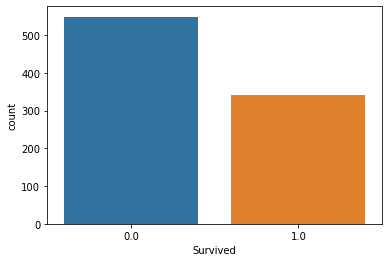

In [25]:
sns.countplot(data = titanic_df, x = 'Survived')

Unique values quantity: 2

Unique values: [ 0.  1. nan]

Null values quantity: 418

Null values: 0.0    549
1.0    342
Name: Survived, dtype: int64


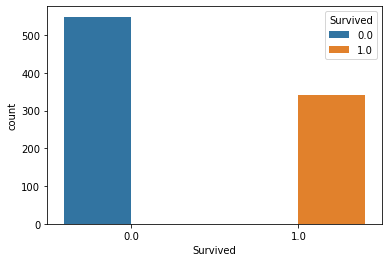

In [26]:
def titanic_func(data, column, count = True):
    print(f'Unique values quantity: {data[column].nunique()}')
    print(f'\nUnique values: {data[column].unique()}')
    print(f'\nNull values quantity: {data[column].isnull().sum()}')
    print(f'\nNull values: {data[column].value_counts()}')
    
    if count == True:
        sns.countplot(data = data, x = column, hue = 'Survived')
    else:
        sns.displot(data[column], kde = True)

titanic_func(titanic_df, 'Survived')

In [27]:
df['Survived'] = titanic_df['Survived']

In [28]:
df

,Survived
0,0.0
1,1.0
2,1.0
3,1.0
4,0.0
...,...
1304,NaN
1305,NaN
1306,NaN
1307,NaN


### PClass

Unique values quantity: 3

Unique values: [3 1 2]

Null values quantity: 0

Null values: 3    709
1    323
2    277
Name: Pclass, dtype: int64


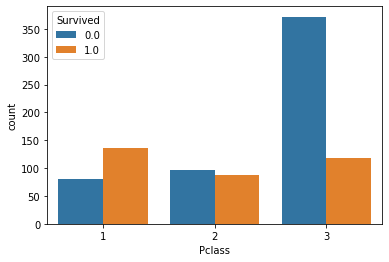

In [29]:
titanic_func(titanic_df, 'Pclass')

In [30]:
df['Pclass'] = titanic_df['Pclass']

In [31]:
df

,Survived,Pclass
0,0.0,3
1,1.0,1
2,1.0,3
3,1.0,1
4,0.0,3
...,...,...
1304,NaN,3
1305,NaN,1
1306,NaN,3
1307,NaN,3


### Sex

In [32]:
titanic_df['Sex'] = titanic_df['Sex'].replace(['male', 'female'], [0,1])

Unique values quantity: 2

Unique values: [0 1]

Null values quantity: 0

Null values: 0    843
1    466
Name: Sex, dtype: int64


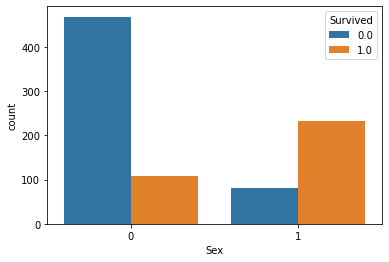

In [33]:
titanic_func(titanic_df, 'Sex')

In [34]:
df['Sex'] = titanic_df['Sex']

In [35]:
df

,Survived,Pclass,Sex
0,0.0,3,0
1,1.0,1,1
2,1.0,3,1
3,1.0,1,1
4,0.0,3,0
...,...,...,...
1304,NaN,3,0
1305,NaN,1,1
1306,NaN,3,0
1307,NaN,3,0


### Age

Unique values quantity: 98

Unique values: [22.   38.   26.   35.     nan 54.    2.   27.   14.    4.   58.   20.
 39.   55.   31.   34.   15.   28.    8.   19.   40.   66.   42.   21.
 18.    3.    7.   49.   29.   65.   28.5   5.   11.   45.   17.   32.
 16.   25.    0.83 30.   33.   23.   24.   46.   59.   71.   37.   47.
 14.5  70.5  32.5  12.    9.   36.5  51.   55.5  40.5  44.    1.   61.
 56.   50.   36.   45.5  20.5  62.   41.   52.   63.   23.5   0.92 43.
 60.   10.   64.   13.   48.    0.75 53.   57.   80.   70.   24.5   6.
  0.67 30.5   0.42 34.5  74.   22.5  18.5  67.   76.   26.5  60.5  11.5
  0.33  0.17 38.5 ]

Null values quantity: 263

Null values: 24.0    47
22.0    43
21.0    41
30.0    40
18.0    39
        ..
23.5     1
70.5     1
55.5     1
20.5     1
38.5     1
Name: Age, Length: 98, dtype: int64


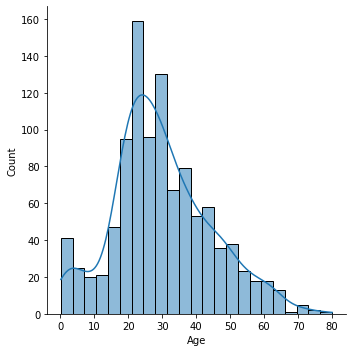

In [36]:
titanic_func(titanic_df, 'Age', False)

In [37]:
titanic_df['Age'].mean()

29.881137667304014

In [38]:
titanic_df.corr()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.038354,-0.013406,0.028814,-0.055224,0.008942,0.031428
Survived,-0.005007,1.000000,-0.338481,0.543351,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.038354,-0.338481,1.000000,-0.124617,-0.408106,0.060832,0.018322,-0.558629
Sex,-0.013406,0.543351,-0.124617,1.000000,-0.063645,0.109609,0.213125,0.185523
Age,0.028814,-0.077221,-0.408106,-0.063645,1.000000,-0.243699,-0.150917,0.178740
SibSp,-0.055224,-0.035322,0.060832,0.109609,-0.243699,1.000000,0.373587,0.160238
Parch,0.008942,0.081629,0.018322,0.213125,-0.150917,0.373587,1.000000,0.221539
Fare,0.031428,0.257307,-0.558629,0.185523,0.178740,0.160238,0.221539,1.000000


In [39]:
for i in sorted(titanic_df['Pclass'].unique()):
    print(f'People from {i} class have average age of: {titanic_df[titanic_df["Pclass"] == i ]["Age"].mean():.0f}')

People from 1 class have average age of: 39
People from 2 class have average age of: 30
People from 3 class have average age of: 25


In [40]:
titanic_df['Age'].isnull().sum()

263

In [41]:
for i in titanic_df.index: 
    if pd.isnull(titanic_df['Age'][i]):    
        if titanic_df['Pclass'][i] == 1:
            titanic_df['Age'][i] = round(titanic_df[titanic_df['Pclass'] == 1]['Age'].mean(), 0)   
        elif titanic_df['Pclass'][i] == 2:
            titanic_df['Age'][i] = round(titanic_df[titanic_df['Pclass'] == 2]['Age'].mean(), 0)   
        elif titanic_df['Pclass'][i] == 3:
            titanic_df['Age'][i] = round(titanic_df[titanic_df['Pclass'] == 3]['Age'].mean(), 0)          
    else:
        continue

C:\Users\lucas\AppData\Local\Temp\ipykernel_13112\1216075247.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_df['Age'][i] = round(titanic_df[titanic_df['Pclass'] == 3]['Age'].mean(), 0)
C:\Users\lucas\AppData\Local\Temp\ipykernel_13112\1216075247.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_df['Age'][i] = round(titanic_df[titanic_df['Pclass'] == 2]['Age'].mean(), 0)
C:\Users\lucas\AppData\Local\Temp\ipykernel_13112\1216075247.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [42]:
titanic_df[titanic_df['Pclass'] == 1]['Age'].isnull().sum()

0

In [43]:
titanic_df['Age'].isnull().sum()

0

In [44]:
titanic_df['Age']

0       22.0
1       38.0
2       26.0
3       35.0
4       35.0
        ... 
1304    25.0
1305    39.0
1306    38.5
1307    25.0
1308    25.0
Name: Age, Length: 1309, dtype: float64

In [45]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   int64  
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(5), object(4)
memory usage: 122.8+ KB


In [46]:
df['Age'] = titanic_df['Age']
df.head()

,Survived,Pclass,Sex,Age
0,0.0,3,0,22.0
1,1.0,1,1,38.0
2,1.0,3,1,26.0
3,1.0,1,1,35.0
4,0.0,3,0,35.0


### SibSp

Unique values quantity: 7

Unique values: [1 0 3 4 2 5 8]

Null values quantity: 0

Null values: 0    891
1    319
2     42
4     22
3     20
8      9
5      6
Name: SibSp, dtype: int64


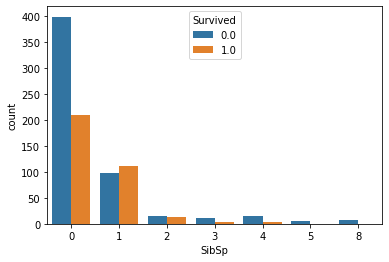

In [47]:
titanic_func(titanic_df, 'SibSp')

In [48]:
df['SibSp'] = titanic_df['SibSp']
df.head()

,Survived,Pclass,Sex,Age,SibSp
0,0.0,3,0,22.0,1
1,1.0,1,1,38.0,1
2,1.0,3,1,26.0,0
3,1.0,1,1,35.0,1
4,0.0,3,0,35.0,0


### Parch

Unique values quantity: 8

Unique values: [0 1 2 5 3 4 6 9]

Null values quantity: 0

Null values: 0    1002
1     170
2     113
3       8
5       6
4       6
6       2
9       2
Name: Parch, dtype: int64


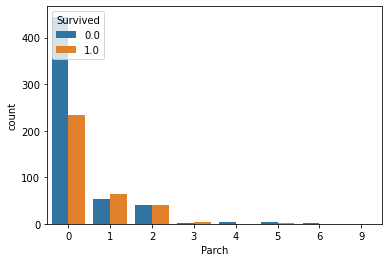

In [49]:
titanic_func(titanic_df, 'Parch')

In [50]:
df['Parch'] = titanic_df['Parch']
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0.0,3,0,22.0,1,0
1,1.0,1,1,38.0,1,0
2,1.0,3,1,26.0,0,0
3,1.0,1,1,35.0,1,0
4,0.0,3,0,35.0,0,0


### Create Family Size

In [51]:
titanic_df['FamilySize'] = titanic_df['SibSp'] + titanic_df['Parch'] + 1 

In [52]:
df['FamilySize'] = titanic_df['FamilySize']
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,FamilySize
0,0.0,3,0,22.0,1,0,2
1,1.0,1,1,38.0,1,0,2
2,1.0,3,1,26.0,0,0,1
3,1.0,1,1,35.0,1,0,2
4,0.0,3,0,35.0,0,0,1


### Fare

Unique values quantity: 281

Unique values: [  7.25    71.2833   7.925   53.1      8.05     8.4583  51.8625  21.075
  11.1333  30.0708  16.7     26.55    31.275    7.8542  16.      29.125
  13.      18.       7.225   26.       8.0292  35.5     31.3875 263.
   7.8792   7.8958  27.7208 146.5208   7.75    10.5     82.1708  52.
   7.2292  11.2417   9.475   21.      41.5792  15.5     21.6792  17.8
  39.6875   7.8     76.7292  61.9792  27.75    46.9     80.      83.475
  27.9     15.2458   8.1583   8.6625  73.5     14.4542  56.4958   7.65
  29.      12.475    9.       9.5      7.7875  47.1     15.85    34.375
  61.175   20.575   34.6542  63.3583  23.      77.2875   8.6542   7.775
  24.15     9.825   14.4583 247.5208   7.1417  22.3583   6.975    7.05
  14.5     15.0458  26.2833   9.2167  79.2      6.75    11.5     36.75
   7.7958  12.525   66.6      7.3125  61.3792   7.7333  69.55    16.1
  15.75    20.525   55.      25.925   33.5     30.6958  25.4667  28.7125
   0.      15.05    39.      22.

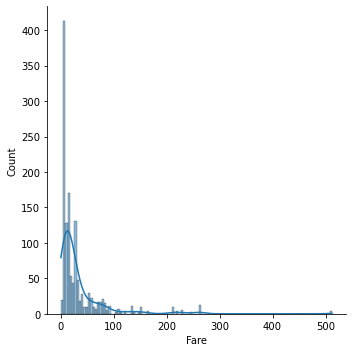

In [53]:
titanic_func(titanic_df, 'Fare', False)

In [54]:
titanic_df[titanic_df['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
1043,1044,NaN,3,"Storey, Mr. Thomas",0,60.5,0,0,3701,NaN,NaN,S,1


In [55]:
titanic_df[titanic_df['Pclass'] == 3]['Fare'].mean()

13.302888700564969

In [56]:
titanic_df['Fare'].fillna(titanic_df[titanic_df['Pclass'] == 3]['Fare'].mean(), inplace = True)

In [57]:
titanic_df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          2
FamilySize        0
dtype: int64

In [58]:
df['Fare'] = titanic_df['Fare']
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,FamilySize,Fare
0,0.0,3,0,22.0,1,0,2,7.2500
1,1.0,1,1,38.0,1,0,2,71.2833
2,1.0,3,1,26.0,0,0,1,7.9250
3,1.0,1,1,35.0,1,0,2,53.1000
4,0.0,3,0,35.0,0,0,1,8.0500


### Cabin

In [59]:
titanic_df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,2


In [60]:
titanic_df['Cabin'].isnull().sum()

1014

In [61]:
titanic_df['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

### Embarked

Unique values quantity: 3

Unique values: ['S' 'C' 'Q' nan]

Null values quantity: 2

Null values: S    914
C    270
Q    123
Name: Embarked, dtype: int64


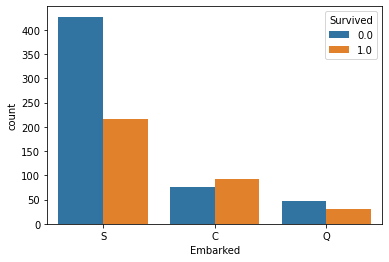

In [62]:
titanic_func(titanic_df, 'Embarked')

In [63]:

titanic_df[titanic_df['Embarked'] == "S"]['Survived'].mean()

0.33695652173913043

In [64]:
titanic_df[titanic_df['Embarked'] == "S"]['Pclass'].mean()

2.3479212253829322

In [65]:
titanic_df[titanic_df['Embarked'] == "C"]['Survived'].mean()

0.5535714285714286

In [66]:
titanic_df[titanic_df['Embarked'] == "C"]['Pclass'].mean()

1.8518518518518519

In [67]:
titanic_df[titanic_df['Embarked'] == "Q"]['Survived'].mean()

0.38961038961038963

In [68]:
titanic_df[titanic_df['Embarked'] == "Q"]['Pclass'].mean()

2.894308943089431

In [69]:
titanic_df[titanic_df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
61,62,1.0,1,"Icard, Miss. Amelie",1,38.0,0,0,113572,80.0,B28,NaN,1
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",1,62.0,0,0,113572,80.0,B28,NaN,1


In [70]:
titanic_df['Embarked'].fillna('C', inplace = True)

In [71]:
titanic_df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          0
FamilySize        0
dtype: int64

In [72]:
df['Embarked'] = titanic_df['Embarked']
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,FamilySize,Fare,Embarked
0,0.0,3,0,22.0,1,0,2,7.2500,S
1,1.0,1,1,38.0,1,0,2,71.2833,C
2,1.0,3,1,26.0,0,0,1,7.9250,S
3,1.0,1,1,35.0,1,0,2,53.1000,S
4,0.0,3,0,35.0,0,0,1,8.0500,S


### Name

In [73]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,2
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,1


In [74]:
titanic_df['Name']

0                                 Braund, Mr. Owen Harris
1       Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                  Heikkinen, Miss. Laina
3            Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                                Allen, Mr. William Henry
                              ...                        
1304                                   Spector, Mr. Woolf
1305                         Oliva y Ocana, Dona. Fermina
1306                         Saether, Mr. Simon Sivertsen
1307                                  Ware, Mr. Frederick
1308                             Peter, Master. Michael J
Name: Name, Length: 1309, dtype: object

In [75]:
titanic_df['Title'] = titanic_df['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())

In [76]:
titanic_df['Title'].nunique()

18

In [77]:
titanic_df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [78]:
titanic_df['Title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: Title, dtype: int64

In [79]:
titanic_df['Title'] = [n if n in ['Mr', 'Miss', 'Mrs', 'Master'] else 'Person' for n in titanic_df['Title']]

In [80]:
titanic_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,2,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,2,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,2,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,1,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",0,25.0,0,0,A.5. 3236,8.0500,NaN,S,1,Mr
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",1,39.0,0,0,PC 17758,108.9000,C105,C,1,Person
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",0,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,1,Mr
1307,1308,NaN,3,"Ware, Mr. Frederick",0,25.0,0,0,359309,8.0500,NaN,S,1,Mr


In [81]:
df['Title'] = titanic_df['Title']
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,FamilySize,Fare,Embarked,Title
0,0.0,3,0,22.0,1,0,2,7.2500,S,Mr
1,1.0,1,1,38.0,1,0,2,71.2833,C,Mrs
2,1.0,3,1,26.0,0,0,1,7.9250,S,Miss
3,1.0,1,1,35.0,1,0,2,53.1000,S,Mrs
4,0.0,3,0,35.0,0,0,1,8.0500,S,Mr


Unique values quantity: 5

Unique values: ['Mr' 'Mrs' 'Miss' 'Master' 'Person']

Null values quantity: 0

Null values: Mr        757
Miss      260
Mrs       197
Master     61
Person     34
Name: Title, dtype: int64


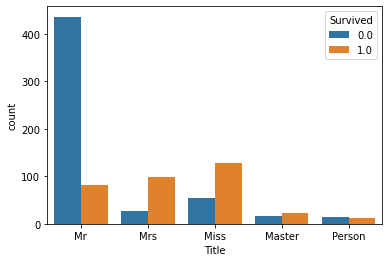

In [82]:
titanic_func(titanic_df, 'Title')

In [83]:
titanic_df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          0
FamilySize        0
Title             0
dtype: int64

In [84]:
pclass = pd.get_dummies(df['Pclass'], prefix = "Pclass", drop_first = True)
title = pd.get_dummies(df['Title'], prefix = 'Title', drop_first = True)
embarked = pd.get_dummies(df['Embarked'], prefix = 'Embarked', drop_first = True)

In [85]:
titanic_full = pd.concat([df, pclass, title, embarked], axis = 1)

In [86]:
titanic_full.drop(['Pclass', 'Title', 'Embarked'], axis=1, inplace=True)

In [87]:
titanic_full

,Survived,Sex,Age,SibSp,Parch,FamilySize,Fare,Pclass_2,Pclass_3,Title_Miss,Title_Mr,Title_Mrs,Title_Person,Embarked_Q,Embarked_S
0,0.0,0,22.0,1,0,2,7.2500,0,1,0,1,0,0,0,1
1,1.0,1,38.0,1,0,2,71.2833,0,0,0,0,1,0,0,0
2,1.0,1,26.0,0,0,1,7.9250,0,1,1,0,0,0,0,1
3,1.0,1,35.0,1,0,2,53.1000,0,0,0,0,1,0,0,1
4,0.0,0,35.0,0,0,1,8.0500,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,0,25.0,0,0,1,8.0500,0,1,0,1,0,0,0,1
1305,NaN,1,39.0,0,0,1,108.9000,0,0,0,0,0,1,0,0
1306,NaN,0,38.5,0,0,1,7.2500,0,1,0,1,0,0,0,1
1307,NaN,0,25.0,0,0,1,8.0500,0,1,0,1,0,0,0,1


In [88]:
train = titanic_full[:train_index].copy()
test = titanic_full[test_index:].copy()

In [89]:
train

,Survived,Sex,Age,SibSp,Parch,FamilySize,Fare,Pclass_2,Pclass_3,Title_Miss,Title_Mr,Title_Mrs,Title_Person,Embarked_Q,Embarked_S
0,0.0,0,22.0,1,0,2,7.2500,0,1,0,1,0,0,0,1
1,1.0,1,38.0,1,0,2,71.2833,0,0,0,0,1,0,0,0
2,1.0,1,26.0,0,0,1,7.9250,0,1,1,0,0,0,0,1
3,1.0,1,35.0,1,0,2,53.1000,0,0,0,0,1,0,0,1
4,0.0,0,35.0,0,0,1,8.0500,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,0,27.0,0,0,1,13.0000,1,0,0,0,0,1,0,1
887,1.0,1,19.0,0,0,1,30.0000,0,0,1,0,0,0,0,1
888,0.0,1,25.0,1,2,4,23.4500,0,1,1,0,0,0,0,1
889,1.0,0,26.0,0,0,1,30.0000,0,0,0,1,0,0,0,0


In [90]:
test

,Survived,Sex,Age,SibSp,Parch,FamilySize,Fare,Pclass_2,Pclass_3,Title_Miss,Title_Mr,Title_Mrs,Title_Person,Embarked_Q,Embarked_S
891,NaN,0,34.5,0,0,1,7.8292,0,1,0,1,0,0,1,0
892,NaN,1,47.0,1,0,2,7.0000,0,1,0,0,1,0,0,1
893,NaN,0,62.0,0,0,1,9.6875,1,0,0,1,0,0,1,0
894,NaN,0,27.0,0,0,1,8.6625,0,1,0,1,0,0,0,1
895,NaN,1,22.0,1,1,3,12.2875,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,0,25.0,0,0,1,8.0500,0,1,0,1,0,0,0,1
1305,NaN,1,39.0,0,0,1,108.9000,0,0,0,0,0,1,0,0
1306,NaN,0,38.5,0,0,1,7.2500,0,1,0,1,0,0,0,1
1307,NaN,0,25.0,0,0,1,8.0500,0,1,0,1,0,0,0,1


In [91]:
train['Survived'] = train['Survived'].astype(int)

In [92]:
train

,Survived,Sex,Age,SibSp,Parch,FamilySize,Fare,Pclass_2,Pclass_3,Title_Miss,Title_Mr,Title_Mrs,Title_Person,Embarked_Q,Embarked_S
0,0,0,22.0,1,0,2,7.2500,0,1,0,1,0,0,0,1
1,1,1,38.0,1,0,2,71.2833,0,0,0,0,1,0,0,0
2,1,1,26.0,0,0,1,7.9250,0,1,1,0,0,0,0,1
3,1,1,35.0,1,0,2,53.1000,0,0,0,0,1,0,0,1
4,0,0,35.0,0,0,1,8.0500,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,27.0,0,0,1,13.0000,1,0,0,0,0,1,0,1
887,1,1,19.0,0,0,1,30.0000,0,0,1,0,0,0,0,1
888,0,1,25.0,1,2,4,23.4500,0,1,1,0,0,0,0,1
889,1,0,26.0,0,0,1,30.0000,0,0,0,1,0,0,0,0


In [93]:
X = train.drop('Survived', axis = 1)
y = train['Survived']

In [94]:
X_test = test.drop('Survived', axis = 1)

### Machine Learning

In [95]:
def func_acc(alg, X_train, y_train, cv):
    model = alg.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    train_pred = model_selection.cross_val_predict(alg, X_train, y_train, cv = cv, n_jobs = -1)    
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return acc, acc_cv

### Random Forest

In [96]:
acc_rf, acc_cv_rf = func_acc(RandomForestClassifier(), X, y, 10)
print(f"Accuracy: {acc_rf}")
print(f"Accuracy CV: {acc_cv_rf}")

Accuracy: 98.32
Accuracy CV: 80.92


### Logistic Regression

In [97]:
acc_log, acc_cv_log = func_acc(LogisticRegression(max_iter = 1000), X, y, 10)

print(f"Accuracy: {acc_log}")
print(f"Accuracy CV: {acc_cv_log}")

Accuracy: 82.94
Accuracy CV: 82.49


### K-Nearest Neighbors

In [98]:
acc_knn, acc_cv_knn = func_acc(KNeighborsClassifier(), X, y, 10)

print(f"Accuracy: {acc_knn}")
print(f"Accuracy CV: {acc_cv_knn}")

Accuracy: 80.81
Accuracy CV: 72.39


### Gaussian Naive Bayes

In [99]:
acc_gaussian, acc_cv_gaussian = func_acc(GaussianNB(), X, y, 10)

print(f"Accuracy: {acc_gaussian}")
print(f"Accuracy CV: {acc_cv_gaussian}")

Accuracy: 78.79
Accuracy CV: 78.56


### SVC

In [100]:
acc_svc, acc_cv_svc = func_acc(LinearSVC(dual = False), X, y, 10)

print(f"Accuracy: {acc_svc}")
print(f"Accuracy CV: {acc_cv_svc}")

Accuracy: 83.28
Accuracy CV: 82.72


### Stochastic Gradient Descent

In [101]:
acc_sgd, acc_cv_sgd = func_acc(SGDClassifier(), X, y, 10)

print(f"Accuracy: {acc_sgd}")
print(f"Accuracy CV: {acc_cv_sgd}")

Accuracy: 72.95
Accuracy CV: 74.19


### Decision Tree Classifiers

In [102]:
acc_dt, acc_cv_dt = func_acc(DecisionTreeClassifier(), X, y, 10)

print(f"Accuracy: {acc_dt}")
print(f"Accuracy CV: {acc_cv_dt}")

Accuracy: 98.32
Accuracy CV: 79.12


### Gradient Boost Classifier

In [103]:
acc_gbc, acc_cv_gbc = func_acc(GradientBoostingClassifier(), X, y, 10)

print(f"Accuracy: {acc_gbc}")
print(f"Accuracy CV: {acc_cv_gbc}")

Accuracy: 89.67
Accuracy CV: 83.28


### Params

In [104]:
params = dict(
    max_depth = [n for n in range(1,5)],
    min_samples_split = [n for n in range(2,6)],
    min_samples_leaf = [n for n in range(2,6)],
    n_estimators = [n for n in range(10,50,10)]
)

In [105]:
gbc = GradientBoostingClassifier()

In [106]:
gbc_cv = GridSearchCV(estimator = gbc, param_grid=params, cv = 10)

In [107]:
gbc_cv.fit(X,y)

GridSearchCV(cv=10, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4],
                         'min_samples_leaf': [2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [10, 20, 30, 40]})

In [108]:
print(f"Best acc: {gbc_cv.best_score_}")
print(f"Best params: {gbc_cv.best_estimator_}")

Best acc: 0.8485143570536829
Best params: GradientBoostingClassifier(max_depth=4, min_samples_leaf=2, n_estimators=30)


In [109]:
gradientBoostingClassifier_pred = gbc_cv.predict(X_test)

In [110]:
kaggle = pd.DataFrame({'PassengerId': passengerId, 'Survived': gradientBoostingClassifier_pred})

kaggle.to_csv('Titanic_gradient_boosting_pred.csv', index=False)